## **Imports**

In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline

## **TABLE/VARIABLES**

In [206]:
df = pd.read_csv('default of credit card clients.csv')
df = df.rename(columns={'PAY_0' : 'PAY_1', 'default payment next month' : 'DEFAULT_0'})

default = 'DEFAULT_0'
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
numeric_features = ['LIMIT_BAL', 'AGE']
ordinal_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_columns = ordinal_features
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
paymnt_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

## **Data EDA**

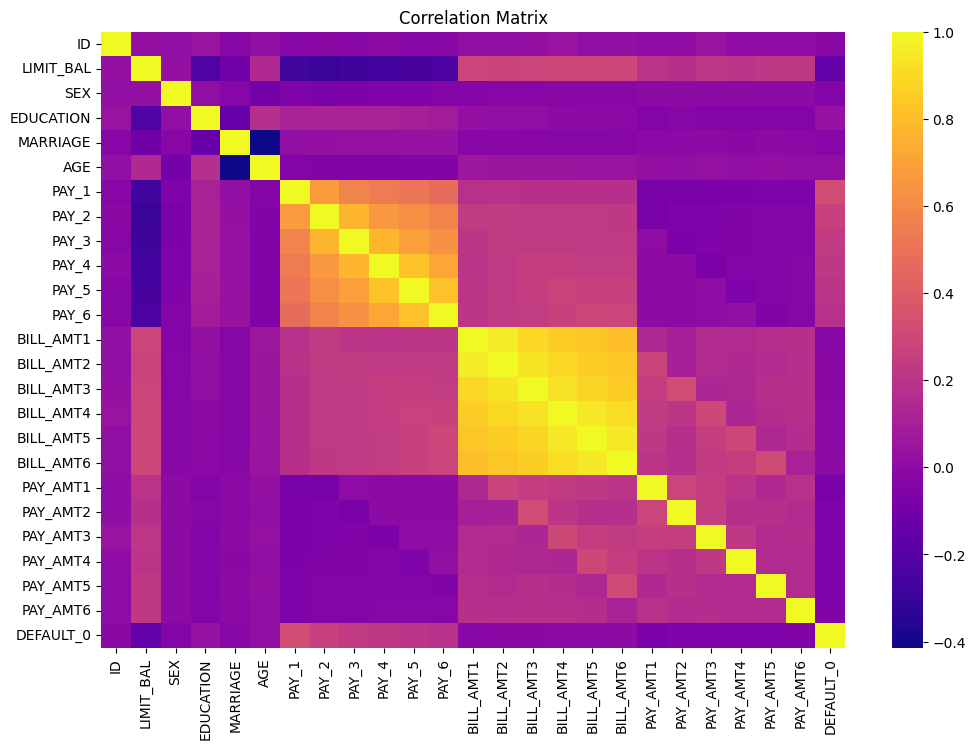

In [207]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='plasma')
plt.title("Correlation Matrix")
plt.show()

### **CATEGORICAL**

In [208]:
df[categorical_features].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [209]:
df = df[df['EDUCATION'] < 4]
df = df[df['MARRIAGE'] != 0]
df[categorical_features].describe()

,SEX,EDUCATION,MARRIAGE
count,29492.000000,29492.000000,29492.000000
mean,1.602875,1.805507,1.555337
std,0.489311,0.698637,0.517985
min,1.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,3.000000,3.000000


### **LIMIT_BAL/AGE**

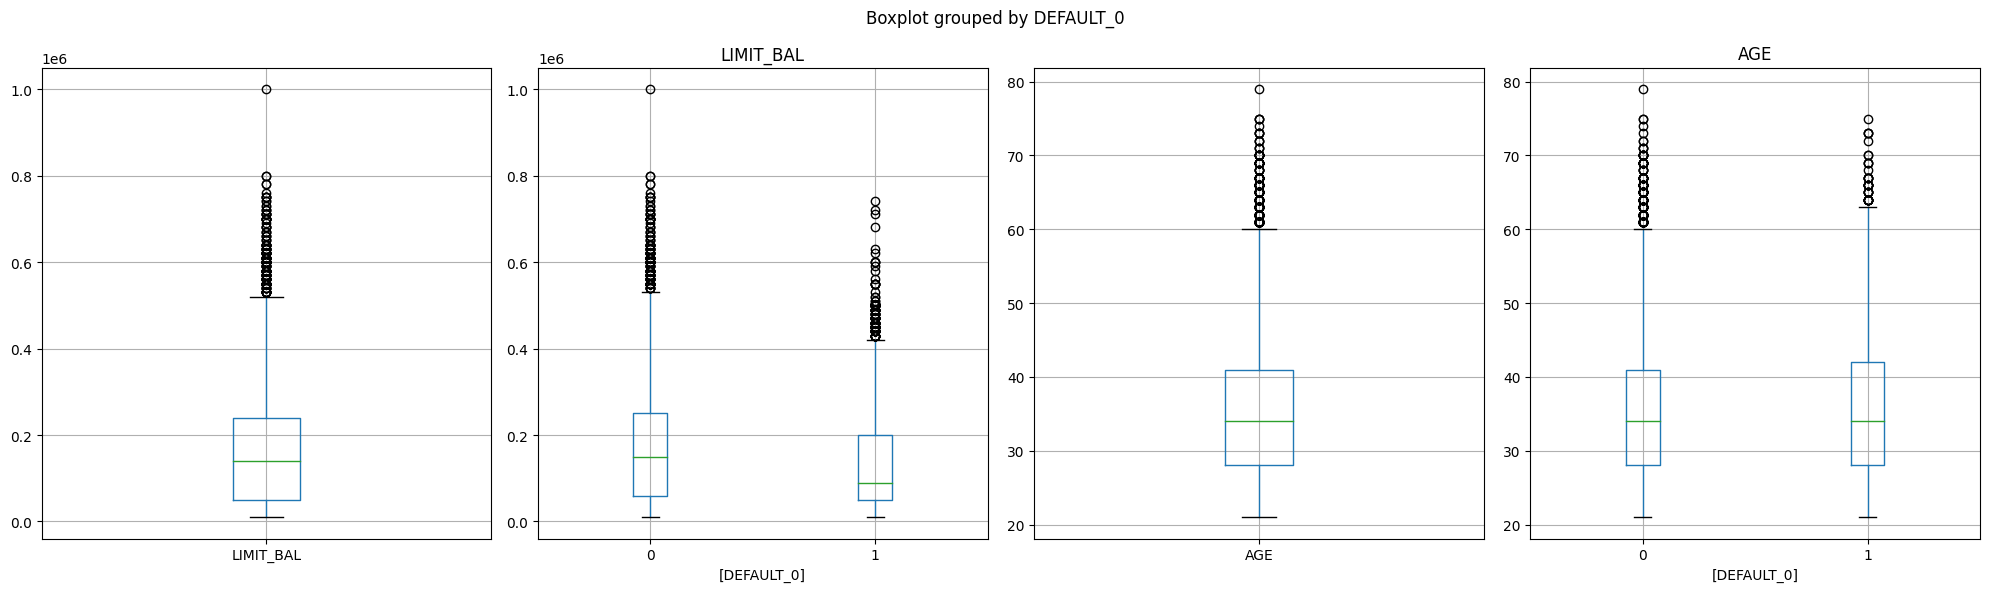

,LIMIT_BAL,AGE
count,29492.000000,29492.000000
mean,167351.609928,35.472399
std,129957.545043,9.216027
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,1000000.000000,79.000000


In [210]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax = ax.flatten()

df.boxplot(column=['LIMIT_BAL'], ax=ax[0])
df.boxplot(column=['LIMIT_BAL'], by=[default], ax=ax[1])
df.boxplot(column=['AGE'], ax=ax[2])
df.boxplot(column=['AGE'], by=[default], ax=ax[3])

plt.tight_layout()
plt.show()

df[['LIMIT_BAL'] + ['AGE']].describe()

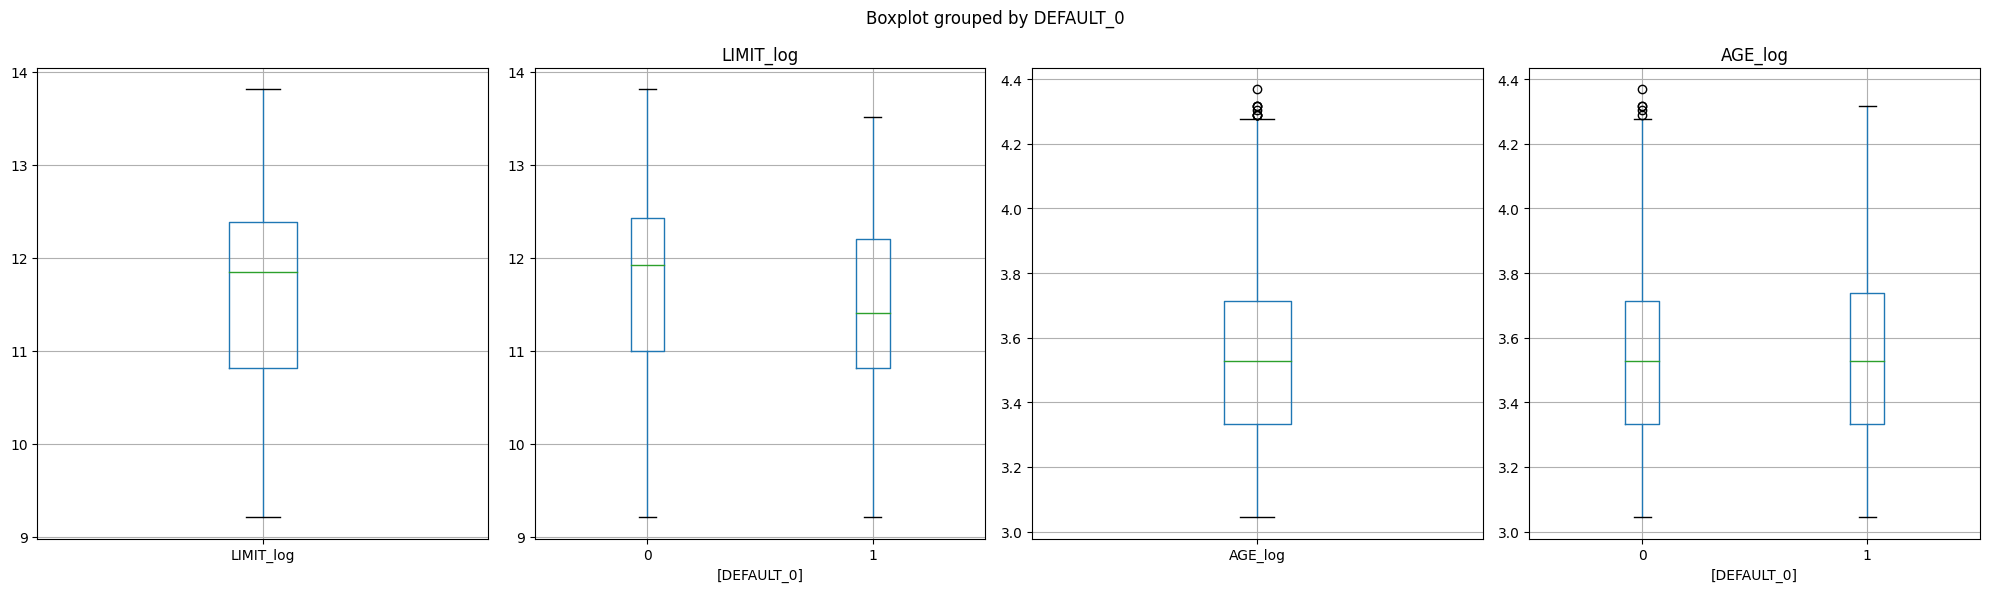

,LIMIT_log,AGE_log
count,29492.000000,29492.000000
mean,11.660819,3.536611
std,0.942453,0.251469
min,9.210340,3.044522
25%,10.819778,3.332205
50%,11.849398,3.526361
75%,12.388394,3.713572
max,13.815511,4.369448


In [211]:
df['LIMIT_log'] = np.log(df['LIMIT_BAL'])
df['AGE_log'] = np.log(df['AGE'])

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax = ax.flatten()

df.boxplot(column=['LIMIT_log'], ax=ax[0])
df.boxplot(column=['LIMIT_log'], by=[default], ax=ax[1])
df.boxplot(column=['AGE_log'], ax=ax[2])
df.boxplot(column=['AGE_log'], by=[default], ax=ax[3])


plt.tight_layout()
plt.show()

df[['LIMIT_log'] + ['AGE_log']].describe()

### **PAY_N**

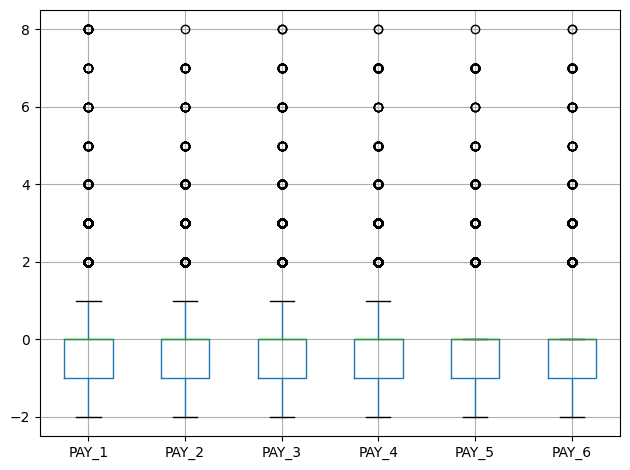

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29492.000000,29492.000000,29492.000000,29492.000000,29492.000000,29492.000000
mean,-0.013122,-0.129052,-0.161298,-0.216126,-0.262207,-0.286179
std,1.124418,1.200138,1.200433,1.172724,1.136617,1.152633
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [212]:
df.boxplot(column=pay_columns)

plt.tight_layout()
plt.show()

df[pay_columns].describe()

In [213]:
for col in pay_columns:
    df[col] = df[col].apply(lambda x: min(x, 6))

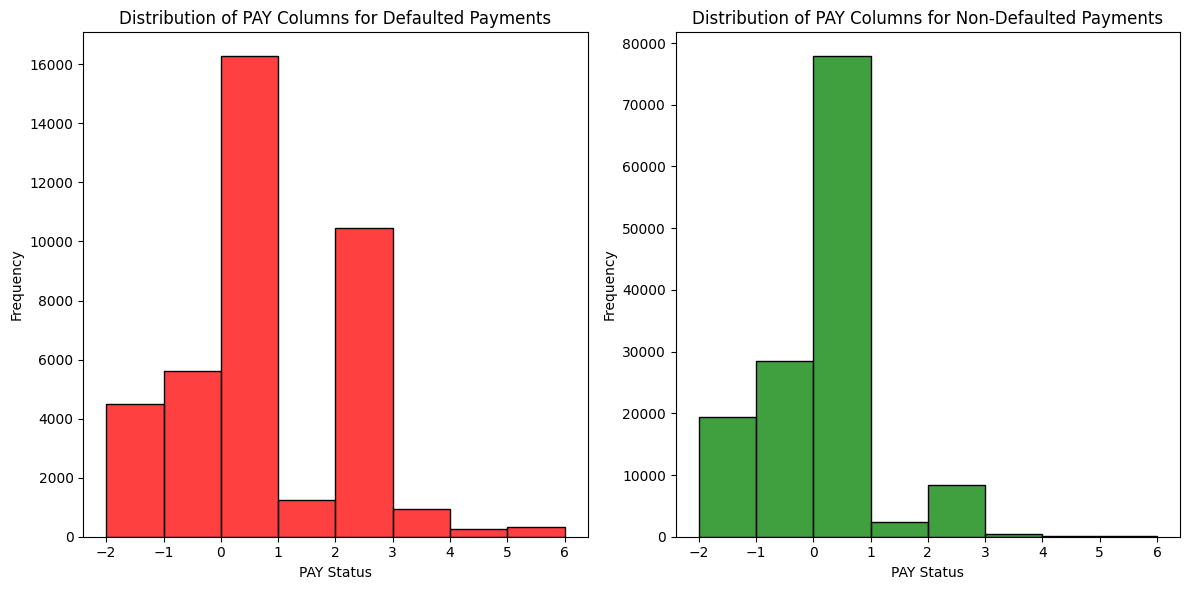

In [214]:
pay_array = df[pay_columns].values.flatten()

defaulted_pay = df[df[default] ==1][pay_columns].values.flatten()
non_defaulted_pay = df[df[default] ==0][pay_columns].values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(defaulted_pay, bins=range(min(pay_array), max(pay_array) + 1), kde=False, ax=axes[0], color='red')
axes[0].set_title('Distribution of PAY Columns for Defaulted Payments')
axes[0].set_xlabel('PAY Status')
axes[0].set_ylabel('Frequency')

sns.histplot(non_defaulted_pay, bins=range(min(pay_array), max(pay_array) + 1), kde=False, ax=axes[1], color='green')
axes[1].set_title('Distribution of PAY Columns for Non-Defaulted Payments')
axes[1].set_xlabel('PAY Status')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [215]:
correlations = {}
p_values = {}

for col in pay_columns:
    coef, p_value = stats.spearmanr(df[col], df[default])
    correlations[col] = coef
    p_values[col] = p_value

for key in correlations.keys():
    print(f"Spearman Correlation for {key}:\nCoefficient={correlations[key]:.3f}\np-value={p_values[key]:.3e}")
    print(f"{'-'*35}")

Spearman Correlation for PAY_1:
Coefficient=0.294
p-value=0.000e+00
-----------------------------------
Spearman Correlation for PAY_2:
Coefficient=0.217
p-value=0.000e+00
-----------------------------------
Spearman Correlation for PAY_3:
Coefficient=0.195
p-value=8.155e-251
-----------------------------------
Spearman Correlation for PAY_4:
Coefficient=0.174
p-value=4.857e-198
-----------------------------------
Spearman Correlation for PAY_5:
Coefficient=0.160
p-value=1.102e-167
-----------------------------------
Spearman Correlation for PAY_6:
Coefficient=0.143
p-value=4.536e-135
-----------------------------------


### **BILL_AMT**

In [216]:
X = sm.add_constant(df[bill_columns])

logit_model = sm.Logit(df[default], X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.531153
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              DEFAULT_0   No. Observations:                29492
Model:                          Logit   Df Residuals:                    29485
Method:                           MLE   Df Model:                            6
Date:                Tue, 07 Nov 2023   Pseudo R-squ.:               0.0007998
Time:                        10:22:20   Log-Likelihood:                -15665.
converged:                       True   LL-Null:                       -15677.
Covariance Type:            nonrobust   LLR p-value:                 0.0003304
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2189      0.017    -71.013      0.000      -1.253      -1.185
BILL_AMT1  -2.325e-06   6.56e

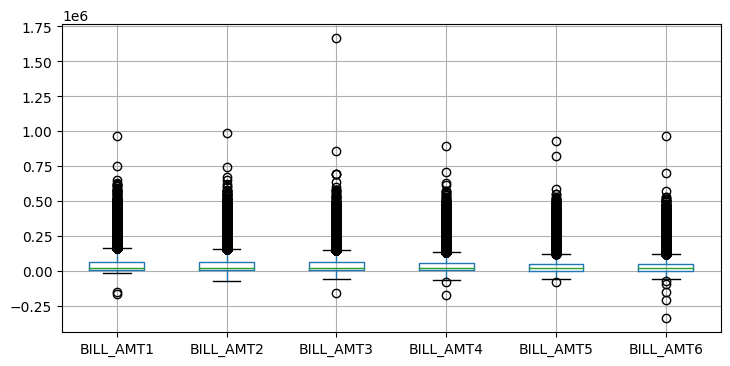

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29492.000000,29492.000000,2.949200e+04,29492.000000,29492.000000,29492.000000
mean,50923.509901,48930.541977,4.679689e+04,43123.236369,40246.635223,38870.542859
std,73333.323294,70910.996712,6.911186e+04,64209.536307,60714.606510,59531.514199
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3556.000000,2986.000000,2.669500e+03,2340.750000,1792.750000,1292.000000
50%,22297.000000,21080.500000,2.005000e+04,19030.500000,18104.500000,17134.000000
75%,66508.750000,63396.000000,5.980025e+04,54064.000000,50069.750000,49132.500000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [217]:
df.boxplot(column=bill_columns, figsize=(8.5, 4))

plt.show()
df[bill_columns].describe()

In [218]:
for col in bill_columns:
    df = df[df[col] >= 0]

for col in bill_columns:
    df[col + 'Exceed'] = df[col] > df['LIMIT_BAL']
    df.drop(col, axis=1, inplace=True)
    contingency_table = pd.crosstab(df[col + 'Exceed'], df[default])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {col + 'Exceed'}:")
    print(f"Chi-squared: {chi2}")
    print(f"p-value: {p}")
    print("--------------------------------------")

Chi-Square Test for BILL_AMT1Exceed:
Chi-squared: 77.93605120592272
p-value: 1.0643103675218023e-18
--------------------------------------
Chi-Square Test for BILL_AMT2Exceed:
Chi-squared: 96.80395847851227
p-value: 7.654292111933962e-23
--------------------------------------
Chi-Square Test for BILL_AMT3Exceed:
Chi-squared: 69.93461163786841
p-value: 6.130328657734476e-17
--------------------------------------
Chi-Square Test for BILL_AMT4Exceed:
Chi-squared: 82.88538046766242
p-value: 8.69519000724168e-20
--------------------------------------
Chi-Square Test for BILL_AMT5Exceed:
Chi-squared: 83.9045290140655
p-value: 5.1925439377826214e-20
--------------------------------------
Chi-Square Test for BILL_AMT6Exceed:
Chi-squared: 81.83539433106873
p-value: 1.4790592488290065e-19
--------------------------------------


### **PAY_AMT**

In [219]:
X = sm.add_constant(df[paymnt_columns])

logit_model = sm.Logit(df[default], X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.524520
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              DEFAULT_0   No. Observations:                27597
Model:                          Logit   Df Residuals:                    27590
Method:                           MLE   Df Model:                            6
Date:                Tue, 07 Nov 2023   Pseudo R-squ.:                 0.02199
Time:                        10:22:21   Log-Likelihood:                -14475.
converged:                       True   LL-Null:                       -14801.
Covariance Type:            nonrobust   LLR p-value:                2.456e-137
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9295      0.019    -49.255      0.000      -0.966      -0.893
PAY_AMT1   -2.175e-05    2.6e

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,27597.000000,2.759700e+04,27597.000000,27597.000000,27597.000000,27597.000000
mean,5664.803384,5.738339e+03,5122.819002,4716.586875,4726.881328,5066.532232
std,16320.960399,1.970506e+04,17018.084626,14827.511003,14485.934297,17204.729385
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1062.000000,1.000000e+03,500.000000,369.000000,350.000000,250.000000
50%,2200.000000,2.070000e+03,1930.000000,1558.000000,1600.000000,1500.000000
75%,5028.000000,5.000000e+03,4601.000000,4100.000000,4145.000000,4005.000000
max,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


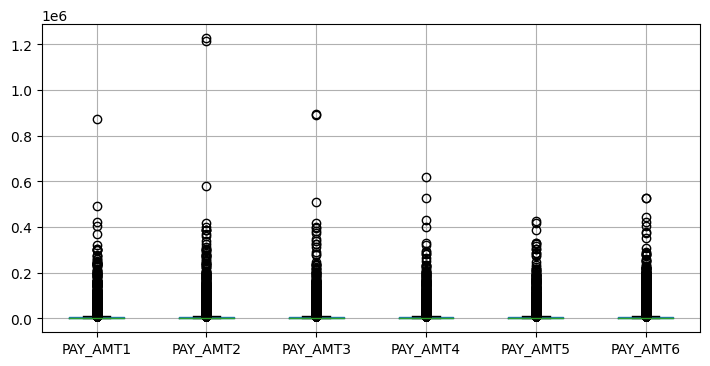

In [220]:
df.boxplot(column=paymnt_columns, figsize=(8.5, 4))
df[paymnt_columns].describe()

Optimization terminated successfully.
         Current function value: 0.515166
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              DEFAULT_0   No. Observations:                27597
Model:                          Logit   Df Residuals:                    27590
Method:                           MLE   Df Model:                            6
Date:                Tue, 07 Nov 2023   Pseudo R-squ.:                 0.03943
Time:                        10:22:21   Log-Likelihood:                -14217.
converged:                       True   LL-Null:                       -14801.
Covariance Type:            nonrobust   LLR p-value:                6.210e-249
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0494      0.037     -1.350      0.177      -0.121       0.022
PAY_AMT1_log    -0.0793

,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log
count,27597.000000,27597.000000,27597.000000,27597.000000,27597.000000,27597.000000
mean,6.735619,6.666623,6.394592,6.190655,6.158254,6.026720
std,3.168418,3.193994,3.266500,3.315592,3.360382,3.460084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.968850,6.908755,6.216606,5.913503,5.860786,5.525453
50%,7.696667,7.635787,7.565793,7.351800,7.378384,7.313887
75%,8.522976,8.517393,8.434246,8.318986,8.329899,8.295549
max,13.680324,14.020150,13.705741,13.339088,12.963438,13.178114


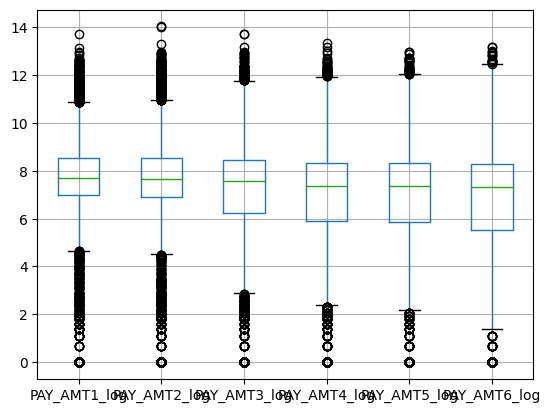

In [221]:
log_paymnt = []
for col in paymnt_columns:
    df[col + '_log'] = np.log(df[col] + 1)
    df.drop(col, axis=1, inplace=True)
    df[col + '_log'].describe()
    log_paymnt.append(col + '_log')

X = sm.add_constant(df[log_paymnt])

logit_model = sm.Logit(df[default], X)
result = logit_model.fit()

print(result.summary())
df.boxplot(column=log_paymnt)
df[log_paymnt].describe()

## **SVM**

In [222]:
df = df.drop(columns=['ID'] + ['LIMIT_BAL'] + ['AGE'], axis=1)
numeric_features = ['LIMIT_log', 'AGE_log'] + log_paymnt

In [223]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('ord', OrdinalEncoder(), ordinal_features)
            ],
    remainder='passthrough' 
)

X = df.drop(columns=[default], axis=1)
y = df[default]

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC(gamma='auto'))
])

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Classification report w/o stratification:\n", classification_report(y_test, y_pred))

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.20, stratify=y)
pipeline.fit(X_train_s, y_train_s)
y_pred_s = pipeline.predict(X_test_s)
print("\nClassification report w/ stratification:\n", classification_report(y_test_s, y_pred_s))

Classification report w/o stratification:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4243
           1       0.66      0.35      0.46      1277

    accuracy                           0.81      5520
   macro avg       0.74      0.65      0.67      5520
weighted avg       0.79      0.81      0.78      5520


Classification report w/ stratification:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      4264
           1       0.68      0.36      0.47      1256

    accuracy                           0.82      5520
   macro avg       0.76      0.66      0.68      5520
weighted avg       0.80      0.82      0.79      5520



In [225]:
num_folds = 3
cv = StratifiedKFold(n_splits=num_folds)

for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    print(f'Classification Report for fold {fold+1}:\n{report}\n')

Classification Report for fold 1:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7105
           1       0.64      0.35      0.45      2094

    accuracy                           0.81      9199
   macro avg       0.73      0.65      0.67      9199
weighted avg       0.79      0.81      0.78      9199


Classification Report for fold 2:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7106
           1       0.68      0.40      0.51      2093

    accuracy                           0.82      9199
   macro avg       0.76      0.67      0.70      9199
weighted avg       0.80      0.82      0.80      9199


Classification Report for fold 3:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      7106
           1       0.74      0.33      0.46      2093

    accuracy                           0.82      9199
   macro avg       0.79 